In [1]:
# Author: Stefania Di Tommaso (sditom@stanford.edu)
# Guide: see HowToDownloadMosaics.docx

import requests
import os
import numpy as np
import pandas as pd
from osgeo import gdal # to crop tile
import imageio

In [2]:
################################################################################
##  Objective: Download MOSAICS RGB given a AOI defined in the bbox variable  ##
################################################################################


####----------------------------Settings------------------------------------####
# Set API key
os.environ['PL_API_KEY'] = '35922faaba86474598eedb60ef2fa78a'
my_auth_key = os.getenv('PL_API_KEY')

# Set AOI file - one large rectangle
# MALAWI
base_dir = os.path.join('..', 'data', 'planet', 'malawi')
bbox_df = pd.read_csv(os.path.join(base_dir, 'bbox_entire_region.csv'), dtype=str)
geojsonFolder = os.path.join(base_dir, 'input_locations', 'geojson')

# Set years and months of interest
year = '_2018_'
months = ['_{}_'.format(str(x).zfill(2)) for x in np.arange(1, 13)]

# Set output Folder
outFolder = os.path.join(base_dir, 'temp_monthly_mosaics')
outFolder_renamed = os.path.join(base_dir, 'monthly_mosaics_renamed') # FINAL FOLDER IF RENAMING FILES

# Set folders used in clipping/merging client side
outFolder_clipped = os.path.join(base_dir, 'temp_monthly_mosaics_renamed_clipped') # TEMPORARY
outFolder_final = os.path.join(base_dir, 'monthly_mosaics_renamed_clipped_merged') # FINAL FOLDER IF CLIP-MERGE FILES
################################################################################

In [3]:
##########------- List All mosaics available with your account------############
headers = {
    'Authorization': 'api-key' + ' ' + my_auth_key,
}
response = requests.get('https://api.planet.com/basemaps/v1/mosaics', headers=headers)
print(response.status_code)

if response.status_code == 200: # ok, proceed
    # print(response.json())
    mosaic_names = []
    for thisMosaic in response.json()['mosaics']:
        mosaic_names.append(thisMosaic['name'])
    # print('All Available mosaics: \n {}'.format(mosaic_names))
else:
    error_msg = 'Error code {}: {}'.format(response.status_code, response.text)
    print(error_msg)
    os.sys.exit(1)
################################################################################

200


In [4]:
########---------- Subset Mosaics to Month-year of interest ----------##########

my_mosaics_year = [m for m in mosaic_names if year in m]
# subset to  January, April, July, October
my_mosaics = []
for mos in my_mosaics_year:
    for mon in months:
        if mon in mos:
            my_mosaics.append(mos)
# print('mosaics: 2018 Jan,Apr,Jul,Oct:  {} \n'.format(my_mosaics))
################################################################################

In [5]:
############## ---------- Retrive List of AOI ----------########################
# print(bbox_df.head(3))
bbox_df["bbox"] = bbox_df["min_lon"] + ',' +\
                  bbox_df["min_lat"] + ',' +\
                  bbox_df["max_lon"] + ',' +\
                  bbox_df["max_lat"]

bbox_list = bbox_df["bbox"].tolist()
bbox_names_list = bbox_df["image_id"].tolist()
# print('AOIs: {} \n'.format(len(bbox_list)))
################################################################################

In [6]:
def tileSearch(mosaic, bbox):
    # Do Tile Search and print on screen
    search_cmd = 'planet mosaics search' + ' ' + mosaic + ' ' + '--bbox' + ' ' + bbox + ' ' + '| jq ."items[].id"'
    output = os.popen(search_cmd).read()
    tile_list = output.split('\n')[:-1]
    print('        {0}: tiles to download:{1}'.format(mosaic,tile_list))


def tileDownload(mosaic, bbox, outdir):
    # save each mosaic-tiles in a separate folder named as year_month
    year_month = '_'.join(mosaic.split('_')[2:4])
    outputFolder = os.path.join(outFolder, outdir, year_month)
    if not os.path.exists(outputFolder):
        # print('Create dir {}..'.format(outputFolder))
        os.makedirs(outputFolder)
    download_cmd = 'planet mosaics download' + ' ' + mosaic + ' ' + '--bbox' + ' ' + bbox + ' ' + '--dest'+ ' ' + outputFolder
    print(download_cmd)
    output = os.popen(download_cmd).read()


def rename_files(outTempFolder, outFinalFolder):
    ######## Script for renaming all the files and save them in a unique folder #########
    ## rename: Aoi_year_month_tileId.tif
    for direc, subdir, listfilename in os.walk(outTempFolder):
        for filename in listfilename:
            dir_yearmonth = os.path.split(direc)[1] #'2018_10'
            dir_aoi = os.path.split(os.path.split(direc)[0])[1] #'7068978'
            new_filename = '_'.join([dir_aoi, dir_yearmonth, filename])
            # print(new_filename)
            src = os.path.join(direc, filename)
            if not os.path.exists(outFinalFolder):
                os.makedirs(outFinalFolder)
            dst = os.path.join(outFinalFolder, new_filename)
            os.rename(src, dst)


def delete_empty_folders(outTempFolder):
    ## Starting from outTempFolder deletes all empty folders
    # Note: after the renaming the files have been moved.
    # so folders should be all empty. if one is not, means something went wrong with renaming.
    # so checking if they are empty before deletinf is a sanity check
    # that all data have been saved in the final folder
    for root, dirs, files in os.walk(outTempFolder, topdown=False):
        for name in dirs:
            thisDir = os.path.join(root, name)
            if not os.listdir(thisDir):
#                 print(thisDir + ' is empty. It will be removed')
                os.rmdir(thisDir)
    # if all folders are empty -> remove Parent folder
    if not os.listdir(outTempFolder):
#         print(outTempFolder + ' is empty. It will be removed')
        os.rmdir(outTempFolder)


def clipQuads(inFolder, geoFolder, outFolder):
    # Clip downloaded quads using AOI geojson files
    bbox_names_list = list(set([f.split('_')[0] for f in os.listdir(inFolder)]))
    print('start clipping')
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    for thisBbox in bbox_names_list:
        thisGeojson = [os.path.join(geoFolder, f) for f in os.listdir(geoFolder) if f.startswith(thisBbox)][0]
        # Find files for this AOI
        thisFiles = [f for f in os.listdir(inFolder) if f.startswith(thisBbox+'_')]
        for thisFile in thisFiles:
            source = os.path.join(inFolder, thisFile)
            output = os.path.join(outFolder, thisFile)
            gdal.Warp(srcDSOrSrcDSTab=source, destNameOrDestDS=output, cutlineDSName=thisGeojson,
                      cropToCutline=True)
    print('done clipping')


def mergeQuads(inFolder, outFolder):
    # merge tiles that belong to same AOI and same Date (year-month)
    bbox_names_list = list(set([f.split('_')[0] for f in os.listdir(inFolder)]))
    date_list = list(set(['_'.join(f.split('_')[1:3]) for f in os.listdir(inFolder)]))
    bbox_date_list = [b+'_'+d for b in bbox_names_list for d in date_list]
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    for thisBboxDate in bbox_date_list:
        thisFiles = [f for f in os.listdir(inFolder) if f.startswith(thisBboxDate+'_')] # list all the files of a same bbox and same date
        input = [os.path.join(inFolder, f) for f in thisFiles]
        output = os.path.join(outFolder, thisBboxDate + '.tif')
        gdal.Warp(srcDSOrSrcDSTab = input, destNameOrDestDS = output)

In [7]:
#############################-----------MAIN-------#############################
start = 0
end = len(bbox_list)

# for i, thisbbox in enumerate(bbox_list[:]):
for i in range(start, end):
    thisbbox = bbox_list[i]
    print('{0}/{1} AOI:{2}, bbox:{3}'.format(i+1, len(bbox_list), bbox_names_list[i], thisbbox))
    outdir = bbox_names_list[i] # name of the AOI
    for thisMosaic in my_mosaics[:]:
#         tileSearch(thisMosaic,thisbbox) # not need to run-just sanity check
        tileDownload(thisMosaic, thisbbox, outdir) # uncomment when ready to start download!

1/1 AOI:entire_region, bbox:33.32624647233237,-13.372057105093067,33.754838063262,-12.686659977771823
planet mosaics download global_monthly_2018_01_mosaic --bbox 33.32624647233237,-13.372057105093067,33.754838063262,-12.686659977771823 --dest ../data/planet/malawi/temp_monthly_mosaics/entire_region/2018_01
planet mosaics download global_monthly_2018_02_mosaic --bbox 33.32624647233237,-13.372057105093067,33.754838063262,-12.686659977771823 --dest ../data/planet/malawi/temp_monthly_mosaics/entire_region/2018_02
planet mosaics download global_monthly_2018_03_mosaic --bbox 33.32624647233237,-13.372057105093067,33.754838063262,-12.686659977771823 --dest ../data/planet/malawi/temp_monthly_mosaics/entire_region/2018_03
planet mosaics download global_monthly_2018_04_mosaic --bbox 33.32624647233237,-13.372057105093067,33.754838063262,-12.686659977771823 --dest ../data/planet/malawi/temp_monthly_mosaics/entire_region/2018_04
planet mosaics download global_monthly_2018_05_mosaic --bbox 33.326246

In [8]:
## Client side processing: Rename, clip, merge
rename_files(outFolder, outFolder_renamed)
delete_empty_folders(outFolder)

Now run `python generate_geojson.py`.

In [9]:
clipQuads(outFolder_renamed, geojsonFolder, outFolder_clipped)

start clipping
done clipping


In [12]:
# merge tiles that belong to same AOI and same date (year-month)
bbox_names_list = ['entire_region']
date_list = sorted(list(set(
    ['_'.join(f.split('_')[2:4]) for f in os.listdir(outFolder_clipped)])))
bbox_date_list = [b+'_'+d for b in bbox_names_list for d in date_list]
if not os.path.exists(outFolder_final):
    os.makedirs(outFolder_final)
for thisBboxDate in bbox_date_list:
    print(thisBboxDate)
    thisFiles = [f for f in os.listdir(outFolder_clipped) if f.startswith(thisBboxDate+'_')] # list all the files of a same bbox and same date
    warp_input = [os.path.join(outFolder_clipped, f) for f in thisFiles]
    warp_output = os.path.join(outFolder_final, thisBboxDate + '.tif')
    gdal.Warp(srcDSOrSrcDSTab = warp_input, destNameOrDestDS = warp_output)

entire_region_2018_01
entire_region_2018_02
entire_region_2018_03
entire_region_2018_04
entire_region_2018_05
entire_region_2018_06
entire_region_2018_07
entire_region_2018_08
entire_region_2018_09
entire_region_2018_10
entire_region_2018_11
entire_region_2018_12


In [12]:
# delete temp folders - especially monthly_mosaics_renamed
import shutil
shutil.rmtree(os.path.join(base_dir, 'monthly_mosaics_renamed'))

In [3]:
# why were some images not clipped?
img_names = os.listdir('../data/planet/ghana/udry/monthly_mosaics_renamed/')

not_clipped = []
for img_name in img_names:
    if not os.path.exists(os.path.join(
        '../data/planet/ghana/udry/temp_monthly_mosaics_renamed_clipped/', img_name)):
        not_clipped.append(img_name)
        print(img_name, "not in clipped folder.")

entire_region_2019_10_L15-1018E-1077N.tif not in clipped folder.
entire_region_2019_09_L15-1020E-1078N.tif not in clipped folder.
entire_region_2019_04_L15-1019E-1076N.tif not in clipped folder.
entire_region_2019_06_L15-1022E-1076N.tif not in clipped folder.
entire_region_2019_12_L15-1024E-1081N.tif not in clipped folder.
entire_region_2019_07_L15-1026E-1081N.tif not in clipped folder.
entire_region_2019_12_L15-1024E-1074N.tif not in clipped folder.
entire_region_2019_12_L15-1016E-1081N.tif not in clipped folder.
entire_region_2019_07_L15-1026E-1076N.tif not in clipped folder.
entire_region_2019_08_L15-1026E-1079N.tif not in clipped folder.
entire_region_2019_06_L15-1026E-1074N.tif not in clipped folder.
entire_region_2019_02_L15-1022E-1076N.tif not in clipped folder.
entire_region_2019_06_L15-1018E-1074N.tif not in clipped folder.
entire_region_2019_02_L15-1017E-1078N.tif not in clipped folder.
entire_region_2019_01_L15-1019E-1080N.tif not in clipped folder.
entire_region_2019_09_L15

#### Clip small tiles from entire region

In [27]:
os.listdir(geojson_dir) 

['00197.geojson',
 '00055.geojson',
 '00414.geojson',
 '00295.geojson',
 '00394.geojson',
 '00044.geojson',
 '00188.geojson',
 'entire_region.geojson',
 '00223.geojson',
 '00090.geojson',
 '00410.geojson']

In [33]:
img_dir = '../data/planet/malawi/monthly_mosaics_renamed_clipped_merged/entire_region/'
geojson_dir = '../data/planet/malawi/input_locations/geojson'
save_dir = '../data/planet/malawi/monthly_mosaics_renamed_clipped_merged'
bbox_csv_path = '../data/planet/malawi/bbox_tiles_overlap.csv'

months = ['2018_{}'.format(str(x).zfill(2)) for x in np.arange(1, 13)]
bbox_names_list = pd.read_csv(bbox_csv_path, dtype=str)['image_id'].values
img_files = ['entire_region_' + month + '.tif' for month in months]

for month in months:
    if not os.path.exists(os.path.join(save_dir, month)):
        os.makedirs(os.path.join(save_dir, month))

for bbox in bbox_names_list:
    bbox_geojson = [os.path.join(geojson_dir, f) for f in os.listdir(geojson_dir) 
                    if f.startswith(bbox)][0]
    print(bbox_geojson)
    for i, img_file in enumerate(img_files):
        month = months[i]
        bbox_img_name = bbox + '_' + month + '.tif'
        source = os.path.join(img_dir, img_file)
        output = os.path.join(save_dir, month, bbox_img_name)
        gdal.Warp(srcDSOrSrcDSTab=source, 
                  destNameOrDestDS=output, 
                  cutlineDSName=bbox_geojson,
                  cropToCutline=True)

../data/planet/malawi/input_locations/geojson/00023.geojson
../data/planet/malawi/input_locations/geojson/00061.geojson
../data/planet/malawi/input_locations/geojson/00076.geojson
../data/planet/malawi/input_locations/geojson/00085.geojson
../data/planet/malawi/input_locations/geojson/00086.geojson
../data/planet/malawi/input_locations/geojson/00092.geojson
../data/planet/malawi/input_locations/geojson/00138.geojson
../data/planet/malawi/input_locations/geojson/00154.geojson
../data/planet/malawi/input_locations/geojson/00166.geojson
../data/planet/malawi/input_locations/geojson/00175.geojson
../data/planet/malawi/input_locations/geojson/00228.geojson
../data/planet/malawi/input_locations/geojson/00236.geojson
../data/planet/malawi/input_locations/geojson/00237.geojson
../data/planet/malawi/input_locations/geojson/00256.geojson
../data/planet/malawi/input_locations/geojson/00284.geojson
../data/planet/malawi/input_locations/geojson/00311.geojson
../data/planet/malawi/input_locations/ge

# Check results

In [14]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

(269, 267, 4)


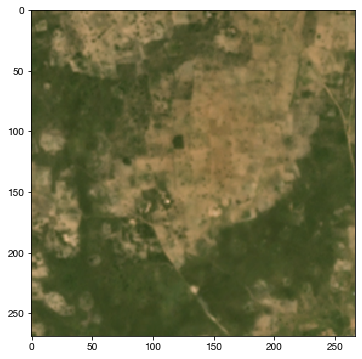

In [32]:
# clipped small itles
renamed = imageio.imread(
    '../data/planet/malawi/monthly_mosaics_renamed_clipped_merged/2018_01/00023_2018_01.tif')
print(renamed.shape)
fig, ax = plt.subplots(1, figsize=(6, 6))
plt.imshow(renamed[:,:,:3])
plt.show()

(16393, 9987, 4)


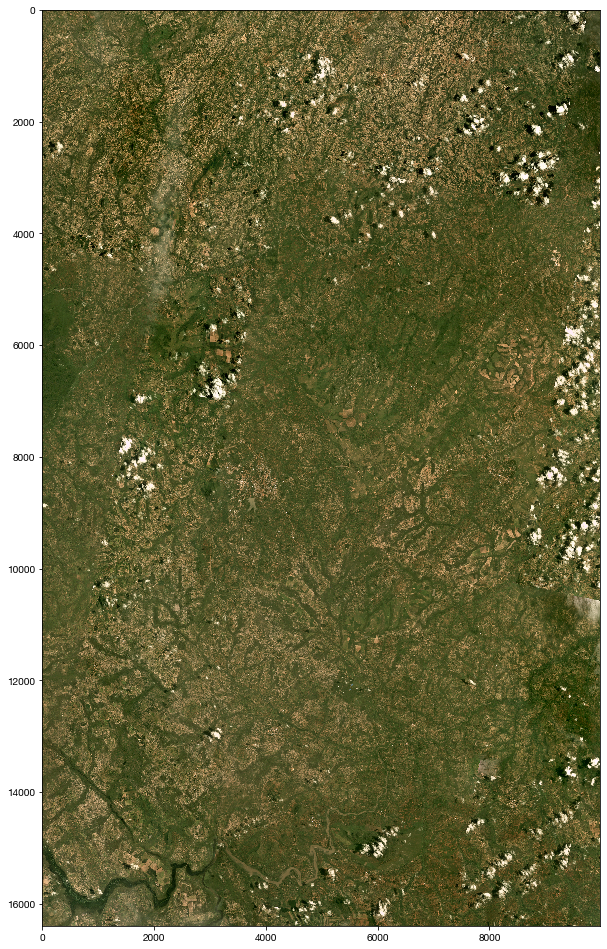

In [25]:
# after merging: visualize entire region (Malawi)
renamed = imageio.imread(
    '../data/planet/malawi/monthly_mosaics_renamed_clipped_merged/entire_region_2018_02.tif')
print(renamed.shape)
fig, ax = plt.subplots(1, figsize=(10, 30))
plt.imshow(renamed[:,:,:3])
plt.show()